# Testing the effect of quantization layers to defend against adversarial attacks

This is the second file!

## Imports and installing QKeras

In [4]:
!pip install git+https://github.com/google/qkeras.git

  Cloning https://github.com/google/qkeras.git to /tmp/pip-req-build-p0v03_ga
  Running command git clone -q https://github.com/google/qkeras.git /tmp/pip-req-build-p0v03_ga
  Created wheel for QKeras: filename=QKeras-0.5.0-cp36-none-any.whl size=31809 sha256=fa59b36f4af2a7580318b6a9f3e1c46aff079a4eba671187df44376762da2798
  Stored in directory: /tmp/pip-ephem-wheel-cache-cbbtwjb2/wheels/06/f6/56/b2086b85ee8cf5f1d7bc1f6bd75faca4fcb214d9703a2459f5
Successfully built QKeras


In [5]:
from qkeras import *

Using TensorFlow backend.


In [0]:
from keras.layers import *
from keras.models import *
from keras.datasets import mnist, cifar10, cifar100
from keras.applications import VGG16
from keras.utils import to_categorical
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# Define some helper functions

def replace_intermediate_layer_in_keras(model, layer_id, new_layer):
    from keras.models import Model

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        else:
            x = layers[i](x)

    new_model = Model(input=layers[0].input, output=x)
    return new_model

def insert_intermediate_layer_in_keras(model, layer_id, new_layer):
    from keras.models import Model

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        x = layers[i](x)

    new_model = Model(input=layers[0].input, output=x)
    return new_model

def train_with_augment(model, x_train, y_train, x_test, y_test, data_augmentation=True, nepochs=25, batch_size=256):
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nepochs,
              validation_data=(x_test, y_test),
              shuffle=True)
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      plt.plot(epochs, acc, 'bo', label='Training acc')
      plt.plot(epochs, val_acc, 'b', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()
      plt.figure()
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'b', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
      history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=nepochs,
                        validation_data=(x_test, y_test),
                        workers=4)
      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      plt.plot(epochs, acc, 'bo', label='Training acc')
      plt.plot(epochs, val_acc, 'b', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()
      plt.figure()
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'b', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

  return model

In [0]:
np.random.seed(42)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
data_augmentation = True
batch_size = 256
nepochs = 25
input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]
print('input_shape: ', input_shape)
print('num_classes: ', num_classes)

170500096/170498071 [==============================] - 6s 0us/step
input_shape:  (32, 32, 3)
num_classes:  10


## We use the same classifier from before but replace the first conv layer with a QActivation and QConv2D layer

In [28]:
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_vgg.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_vgg.input, outputs=x)
opt = Adam(0.001)
model.load_weights('base_classifier_weights.hdf5')

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
qxactiv = QActivation('quantized_relu_po2(4,1)')
qx = QConv2D(64, (3,3), strides=(1,1), 
             name='QConv2D', padding='same', activation='relu', 
             kernel_quantizer='quantized_po2(4,1)', bias_quantizer='quantized_po2(4,1)')

In [0]:
qmodel = insert_intermediate_layer_in_keras(model, 1, qxactiv)
qmodel = replace_intermediate_layer_in_keras(qmodel, 2, qx)

In [39]:
qmodel = Model(inputs=qmodel.input, outputs=qmodel.output)
opt = Adam(0.001)
qmodel.summary();

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
q_activation_2 (QActivation) (None, 32, 32, 3)         0         
_________________________________________________________________
QConv2D (QConv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       1475

In [0]:
qmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
196/196 [==============================] - 53s 270ms/step - loss: 1.6672 - acc: 0.4013 - val_loss: 1.1449 - val_acc: 0.6070
Epoch 2/25
196/196 [==============================] - 45s 231ms/step - loss: 1.0895 - acc: 0.6318 - val_loss: 0.8754 - val_acc: 0.7111
Epoch 3/25
196/196 [==============================] - 45s 231ms/step - loss: 0.8674 - acc: 0.7090 - val_loss: 0.7673 - val_acc: 0.7486
Epoch 4/25
196/196 [==============================] - 45s 231ms/step - loss: 0.7718 - acc: 0.7414 - val_loss: 0.7529 - val_acc: 0.7485
Epoch 5/25
196/196 [==============================] - 45s 231ms/step - loss: 0.6997 - acc: 0.7676 - val_loss: 0.6933 - val_acc: 0.7727
Epoch 6/25
196/196 [==============================] - 45s 231ms/step - loss: 0.6714 - acc: 0.7757 - val_loss: 0.6781 - val_acc: 0.7814
Epoch 7/25
196/196 [==============================] - 45s 231

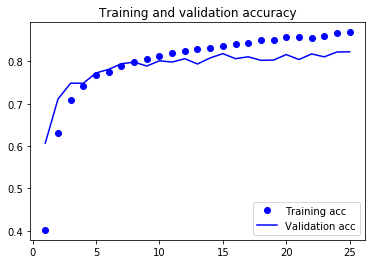

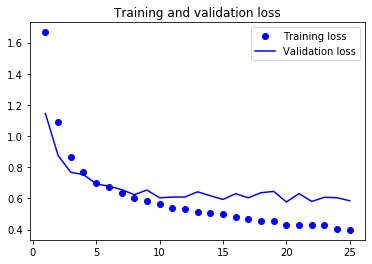

In [41]:
qmodel = train_with_augment(qmodel, x_train, y_train, x_test, y_test)

In [0]:
qmodel.save_weights('q1_classifier_weights.hdf5')
qmodel.save('q1_classifier.hdf5')

## Test the new quantized model against normal and adversarial images

In [0]:
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_vgg.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_vgg.input, outputs=x)
opt = Adam(0.001)
model.load_weights('base_classifier_weights.hdf5')

In [44]:
qxactiv = QActivation('quantized_relu_po2(4,1)')
qx = QConv2D(64, (3,3), strides=(1,1), 
             name='QConv2D', padding='same', activation='relu', 
             kernel_quantizer='quantized_po2(4,1)', bias_quantizer='quantized_po2(4,1)')
qmodel = insert_intermediate_layer_in_keras(model, 1, qxactiv)
qmodel = replace_intermediate_layer_in_keras(qmodel, 2, qx)
qmodel = Model(inputs=qmodel.input, outputs=qmodel.output)
opt = Adam(0.001)
qmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
qmodel.load_weights('q1_classifier_weights.hdf5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
class_names = ['airplane', 'automobile', 
               'bird', 'cat', 
               'deer', 'dog', 
               'frog', 'horse', 
               'ship', 'truck']

Text(0.5, 1.05, 'Sample')

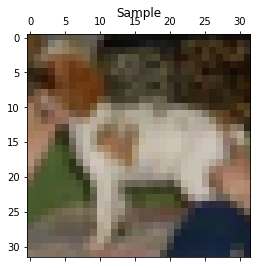

In [46]:
sample_index = 12
sample = x_test[sample_index]
sample_preds = qmodel.predict(np.array([sample])).flatten()
sample_label = np.argmax(y_test[sample_index])
plt.matshow(sample)
plt.title('Sample')

Text(0.5, 1.0, 'Predictions for class dog')

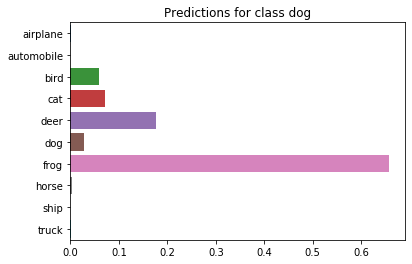

In [47]:
ax = sns.barplot(x=sample_preds, y=class_names)
ax.set_title('Predictions for class ' + class_names[sample_label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.05, 'Adversarial Sample')

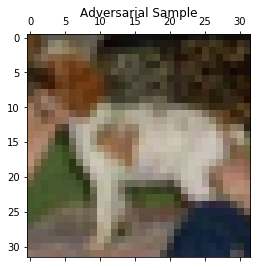

In [48]:
adv_samples = np.load('adv_samples.npy')
adv_sample = adv_samples[sample_index]
adv_preds = qmodel.predict(np.array([adv_sample])).flatten()
plt.matshow(adv_sample)
plt.title('Adversarial Sample')

Text(0.5, 1.0, 'Predictions for class dog')

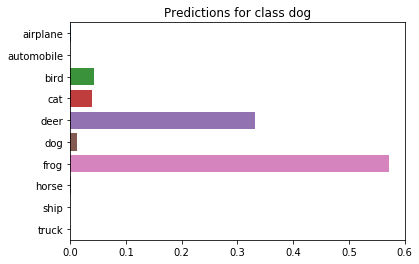

In [49]:
ax = sns.barplot(x=adv_preds, y=class_names)
ax.set_title('Predictions for class ' + class_names[sample_label])

In [50]:
preds = qmodel.predict([x_test])
normal_acc = np.mean(np.argmax(np.round(preds,0), axis=1) == np.argmax(y_test, axis=1))
print('normal accuracy: ', normal_acc, 
      '\nnormal avg stddev: ', np.mean(np.std(preds, axis=1)))

normal accuracy:  0.7998 
normal avg stddev:  0.2616609


In [0]:
adv_preds = qmodel.predict([adv_samples])
sample_labels = y_test

In [52]:
adv_acc = np.mean(np.argmax(np.round(adv_preds,0), axis=1) == np.argmax(y_test, axis=1))
print('adversarial accuracy: ', adv_acc, 
      '\nadversarial avg stddev: ', np.mean(np.std(adv_preds, axis=1)))

adversarial accuracy:  0.718 
adversarial avg stddev:  0.25420687


We see that, while the quantized model performs slightly worse than the normal model on the original image dataset, it performs much better than the normal model on the adversarial dataset. Next steps are to try this with different epsilons (proportion of noise to add) in generating adversarial samples, other datasets, and other base classifiers. 